Data Initialzation and training model selction.

During this process, the wild fires data set has been retrieved through open source github link. This dataest contains state of the crops (NDVI), meteorological conditions (LST), and the fire indicator “Thermal Anomalies”.The Dataset: Normalised Difference Vegetation Index (NDVI): indicates the state of crop health, it can be used to assess spatiotemporal changes in green vegetation.	LST	Land Surface Temperature(LST): represents the radiative skin temperature of land surface derived from solar radiation, depends on vegetation cover and th soi moisture. The study area is composed of multiple zones located in the center of Canada.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, balanced_accuracy_score

df = pd.read_csv('https://github.com/ouladsayadyounes/WildFires/raw/master/WildFires_DataSet.csv')
label_encoder = LabelEncoder()
df['CLASS'] = label_encoder.fit_transform(df['CLASS'])
df['LST'] *= 0.02
df['LST'] -= 273.15
df.groupby('CLASS').count()

,NDVI,LST,BURNED_AREA
CLASS,,,
0,386,386,386
1,1327,1327,1327


The data has been normalized and preprossed. The data has been split to 80%/20% for trainning and testing. Through the Scikit-learn toolkit, the models used for this project are Multilayed Perceptioin Classifier and Random Forset Classifier. MLP was chosen because of its capacity to represent complicated, nonlinear interactions in data, making it suitable for comprehending the dataset's deep interplays. Random Forest, on the other hand, excels at dealing with high-dimensional data, providing adaptability as well as deep feature significance evaluations. It is more capable of handling with various data distributions and making solid predictions, especially in the presence of outliers and unbalanced datasets. We choose to compare the performance of these two models.

We trained the model without any model fitting or parameter tuning at first. The predict reports, as seen below, indicate a poor degree of model accuracy.

In [15]:
from sklearn.neural_network import MLPClassifier

# Preparing the data
X = df.drop('CLASS', axis=1) 
y = df['CLASS']             
# Splitting dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Feature scaling for normalization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train) 
X_test = scaler.transform(X_test)        

# MLP Classifier
mlp = MLPClassifier(hidden_layer_sizes=(21,21,21), max_iter=500, random_state=42)
mlp.fit(X_train, y_train)           

# Predictions and Evaluation for MLP
y_pred = mlp.predict(X_test)
print("MLPClassifier Accuracy:", balanced_accuracy_score(y_test, y_pred))
print("MLPClassifier Classification Report:\n", classification_report(y_test, y_pred))

from sklearn.ensemble import RandomForestClassifier

# RandomForest Classifier
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train, y_train)               

# Predictions and Evaluation for Random Forest
y_pred = rfc.predict(X_test)
print("\nRandomForestClassifier Accuracy:", balanced_accuracy_score(y_test, y_pred))
print("RandomForestClassifier Classification Report:\n", classification_report(y_test, y_pred))

c:\Users\s1298\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier Accuracy: 0.6154939587775409
MLPClassifier Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.29      0.39       112
           1       0.83      0.95      0.88       402

    accuracy                           0.80       514
   macro avg       0.71      0.62      0.63       514
weighted avg       0.78      0.80      0.77       514


RandomForestClassifier Accuracy: 0.7085110163468373
RandomForestClassifier Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.46      0.57       112
           1       0.86      0.95      0.91       402

    accuracy                           0.85       514
   macro avg       0.80      0.71      0.74       514
weighted avg       0.84      0.85      0.83       514



Hyper parameter tuning

The hyperparameter tuning is conducted in two stages. Initially, RandomizedSearchCV is utilized for both models, efficiently exploring a broad range of hyperparameters to identify promising combinations. This approach is particularly effective due to its ability to sample diverse parameter settings, providing a balance between exploring a wide parameter space and focusing on areas with high potential.

Following the initial exploration, GridSearchCV is employed to finely tune the models within the narrowed parameter range identified by RandomizedSearchCV. This step involves an exhaustive search over the specified range, ensuring that the best possible parameter combination is identified for each model. The use of GridSearchCV is crucial for achieving the highest model accuracy, as it meticulously evaluates every possible combination within the targeted hyperparameter space.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import joblib
from random import sample

data = pd.read_csv('https://github.com/ouladsayadyounes/WildFires/raw/master/WildFires_DataSet.csv')
X = data.drop('CLASS', axis=1)
y = data['CLASS']

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Setting up the parameter range for RandomizedSearchCV for MLPClassifier
alpha_range = np.logspace(-6, 0, 10000)
random_params_mlpc = {
    'hidden_layer_sizes': [(200, 200), (50, 50, 50), (100, 100, 100)],
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'alpha': alpha_range
}

# Setting up the parameter range for RandomizedSearchCV for RandomForestClassifier
random_params_rf = {
    'n_estimators': sample(range(50, 450), 400),
    'max_depth': sample(range(2, 15), 13),
    'min_samples_split': sample(range(2, 15), 13),
    'min_samples_leaf': sample(range(1, 15), 14),
    'max_features': [3]
}

# Initializing the classifiers
mlpc = MLPClassifier(max_iter=300, random_state=42)
rf = RandomForestClassifier(random_state=42)

# Performing Randomized Search for hyperparameter tuning
random_search_mlpc = RandomizedSearchCV(mlpc, random_params_mlpc, n_iter=100, cv=5, n_jobs=-1, random_state=42, verbose=3)
random_search_rf = RandomizedSearchCV(rf, random_params_rf, n_iter=100, cv=5, n_jobs=-1, random_state=42, verbose=3)

print("Randomized search for MLPClassifier...")
random_search_mlpc.fit(X_train_scaled, y_train)
print("Randomized search for RandomForestClassifier...")
random_search_rf.fit(X_train_scaled, y_train)

# Extracting best parameters from Randomized Search
best_params_mlpc = random_search_mlpc.best_params_
best_params_rf = random_search_rf.best_params_

# Setting up parameters for GridSearchCV based on Randomized Search results
wp = 0.12
n = 9
grid_params_mlpc = {
    'hidden_layer_sizes': [best_params_mlpc['hidden_layer_sizes']],
    'activation': [best_params_mlpc['activation']],
    'alpha': best_params_mlpc['alpha'] * (1 + np.linspace(-wp, wp, n))
}
grid_params_rf = {
    'n_estimators': [int(best_params_rf['n_estimators'] * (1 + x)) for x in np.linspace(-wp, wp, n)],
    'max_depth': [int(best_params_rf['max_depth'] + x) for x in range(-2, 3)],
    'min_samples_split': [best_params_rf['min_samples_split'] + x for x in range(-1, 2)],
    'min_samples_leaf': [best_params_rf['min_samples_leaf'] + x for x in range(-1, 2)]
}

# Performing Grid Search for fine-tuning the models
grid_search_mlpc = GridSearchCV(mlpc, grid_params_mlpc, cv=5, n_jobs=-1, verbose=3)
grid_search_rf = GridSearchCV(rf, grid_params_rf, cv=5, n_jobs=-1, verbose=3)

print("Grid search for MLPClassifier...")
grid_search_mlpc.fit(X_train_scaled, y_train)
print("Grid search for RandomForestClassifier...")
grid_search_rf.fit(X_train_scaled, y_train)

joblib.dump(grid_search_mlpc.best_estimator_, 'mlpc_model.joblib')
joblib.dump(grid_search_rf.best_estimator_, 'rf_model.joblib')


The prediction results are shown below. Through the tuning process, the accuracy has achieved a level higher than before. However, hyperparameter tuning requires significant computing power to converge the model, which increases the cost of the training process.

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import joblib
from sklearn.metrics import accuracy_score, classification_report

url = "https://github.com/ouladsayadyounes/WildFires/raw/master/WildFires_DataSet.csv"
data = pd.read_csv(url)

X = data.drop('CLASS', axis=1) 
y = data['CLASS']              
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  
X_test_scaled = scaler.transform(X_test)     
   
# Loading the trained MLPClassifier and RandomForest models
mlpc_model = joblib.load('mlpc_model.joblib')
rf_model = joblib.load('rf_model.joblib')

# Making predictions and evaluating the MLPClassifier
y_pred_mlpc = mlpc_model.predict(X_test_scaled)
accuracy_mlpc = accuracy_score(y_test, y_pred_mlpc)
print("MLPClassifier Accuracy:", accuracy_mlpc)
print("MLPClassifier Classification Report:\n", classification_report(y_test, y_pred_mlpc))

# Making predictions and evaluating the RandomForestClassifier
y_pred_rf = rf_model.predict(X_test_scaled)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("\nRandomForestClassifier Accuracy:", accuracy_rf)
print("RandomForestClassifier Classification Report:\n", classification_report(y_test, y_pred_rf))


MLPClassifier Accuracy: 0.791828793774319
MLPClassifier Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.23      0.33       112
           1       0.82      0.95      0.88       402

    accuracy                           0.79       514
   macro avg       0.68      0.59      0.60       514
weighted avg       0.76      0.79      0.76       514


RandomForestClassifier Accuracy: 0.8268482490272373
RandomForestClassifier Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.32      0.45       112
           1       0.84      0.97      0.90       402

    accuracy                           0.83       514
   macro avg       0.79      0.64      0.67       514
weighted avg       0.81      0.83      0.80       514



Tuning ensemble classifier

The use of Voting and Stacking Classifiers in this project aims to enhance the accuracy of wildfire predictions by combining the strengths of MLPClassifier and RandomForestClassifier. The Voting Classifier, using 'soft' voting, aggregates the probabilistic predictions from both models, capitalizing on their individual strengths and offering a robust, unified prediction. This method excels when combining diverse, independently effective models, as it mitigates their individual weaknesses and leverages their collective insights.

Conversely, the Stacking Classifier adopts a layered approach, where the base models' predictions are inputs for a final Logistic Regression estimator. This technique not only amalgamates predictions but also allows the final estimator to learn how to optimally integrate these predictions, harnessing the distinct prediction patterns of each base model. Stacking, therefore, provides a nuanced method of combining model outputs, potentially leading to more accurate and reliable predictions in complex scenarios like wildfire analysis.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import joblib

mlpc_model = joblib.load('mlpc_model.joblib')
rf_model = joblib.load('rf_model.joblib')

url = "https://github.com/ouladsayadyounes/WildFires/raw/master/WildFires_DataSet.csv"
data = pd.read_csv(url)

X = data.drop('CLASS', axis=1)
y = data['CLASS']

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) 
X_test_scaled = scaler.transform(X_test)       

# Voting Classifier
voting_clf = VotingClassifier(estimators=[('mlpc', mlpc_model), ('rf', rf_model)], voting='soft')
voting_clf.fit(X_train_scaled, y_train)

# Stacking Classifier
stacking_clf = StackingClassifier(estimators=[('mlpc', mlpc_model), ('rf', rf_model)], final_estimator=LogisticRegression())
stacking_clf.fit(X_train_scaled, y_train)

acc_voting = accuracy_score(y_test, voting_clf.predict(X_test_scaled))
acc_stacking = accuracy_score(y_test, stacking_clf.predict(X_test_scaled))
if acc_voting > acc_stacking:
    best_model = voting_clf
    print("Voting Classifier selected.")
else:
    best_model = stacking_clf
    print("Stacking Classifier selected.")

print(f"Best Model Accuracy: {max(acc_voting, acc_stacking):.4f}")

joblib.dump(best_model, 'best_model.joblib')
print("Best Ensemble Model saved successfully.")

# Making predictions and evaluating the Best model
y_pred= best_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))

c:\Users\s1298\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\s1298\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\s1298\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Stacking Classifier selected.
Best Model Accuracy: 0.8210
Best Ensemble Model saved successfully.
Accuracy: 0.8210116731517509
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.30      0.42       112
           1       0.83      0.97      0.89       402

    accuracy                           0.82       514
   macro avg       0.77      0.63      0.66       514
weighted avg       0.81      0.82      0.79       514



Model evaluation

All models are evaluated against test data. ROC curves and Confusion Matrix are produced for each.

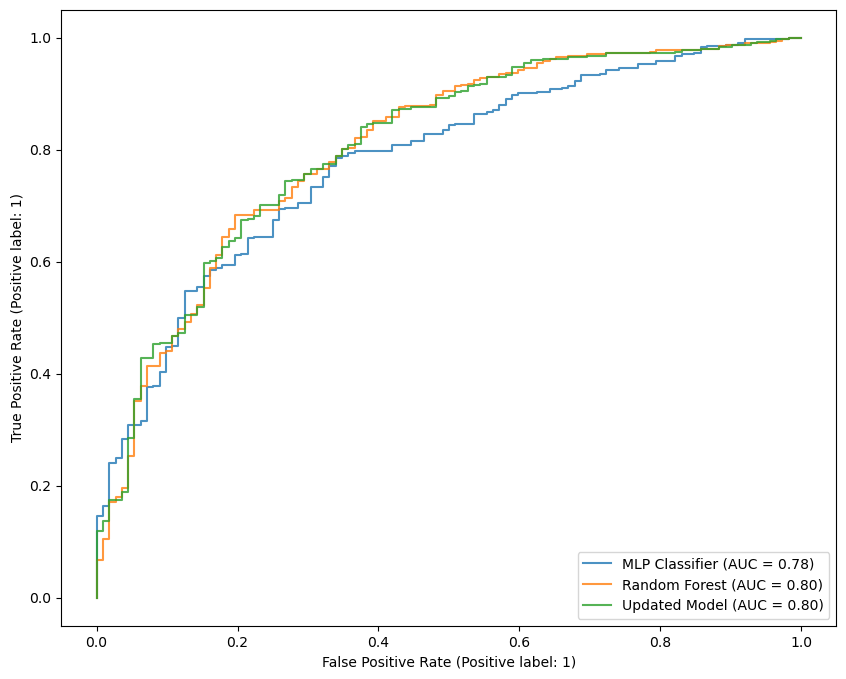

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
import joblib

# Load the models from saved files
mlpc_model = joblib.load('mlpc_model.joblib')
rf_model = joblib.load('rf_model.joblib')
best_model = joblib.load('best_model.joblib')

# Set up the plot for ROC curves
fig = plt.figure(figsize=(10, 8))  # Creating a figure with specified size
ax = plt.gca()                     # Getting the current Axes instance on the current figure

# Plotting ROC Curve 
RocCurveDisplay.from_estimator(mlpc_model, X_test_scaled, y_test, ax=ax, name='MLP Classifier', alpha=0.8)
RocCurveDisplay.from_estimator(rf_model, X_test_scaled, y_test, ax=ax, name='Random Forest', alpha=0.8)
RocCurveDisplay.from_estimator(best_model, X_test_scaled, y_test, ax=ax, name='Updated Model', alpha=0.8)
plt.show()


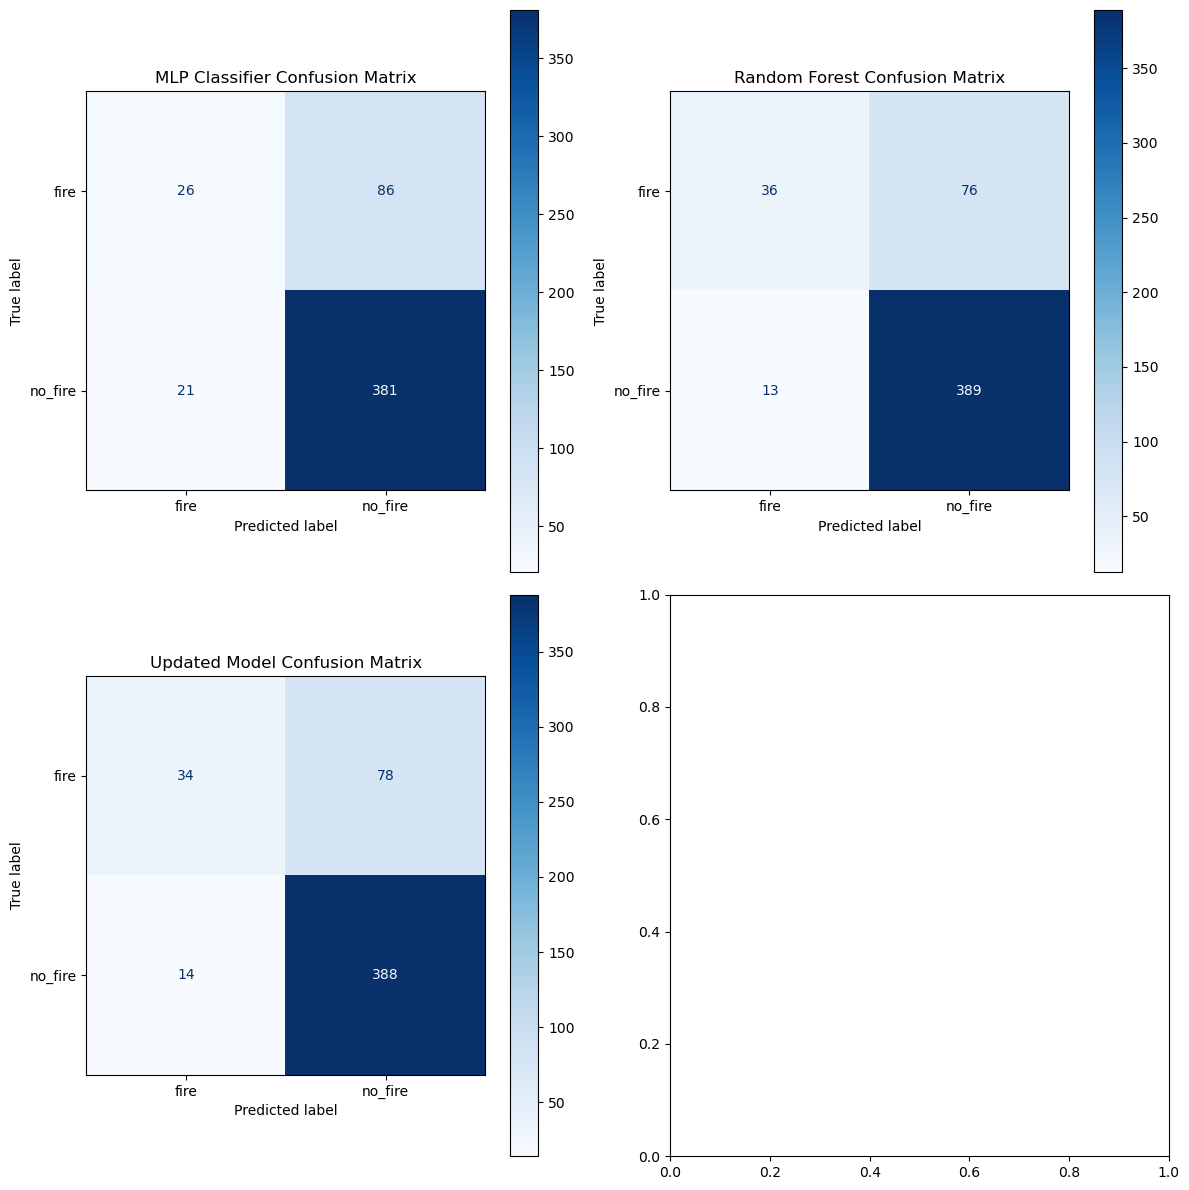

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import joblib
import matplotlib.pyplot as plt

# Load the models from saved files
mlpc_model = joblib.load('mlpc_model.joblib')
rf_model = joblib.load('rf_model.joblib')
best_model = joblib.load('best_model.joblib')

# Making predictions using the loaded models
y_pred_mlpc = mlpc_model.predict(X_test_scaled)
y_pred_rf = rf_model.predict(X_test_scaled)
y_pred_updated= best_model.predict(X_test_scaled)

# Computing confusion matrices for each model
cm_mlpc = confusion_matrix(y_test, y_pred_mlpc)
cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_updated = confusion_matrix(y_test, y_pred_updated)

# Setting up the subplot for displaying multiple confusion matrices
fig, ax = plt.subplots(2, 2, figsize=(12, 12))  # Creating a 2x2 grid of subplots

# Plotting confusion matrix
ConfusionMatrixDisplay(cm_mlpc, display_labels=label_encoder.classes_).plot(ax=ax[0,0], cmap='Blues')
ax[0,0].set_title('MLP Classifier Confusion Matrix')
ConfusionMatrixDisplay(cm_rf, display_labels=label_encoder.classes_).plot(ax=ax[0,1], cmap='Blues')
ax[0,1].set_title('Random Forest Confusion Matrix')
ConfusionMatrixDisplay(cm_updated, display_labels=label_encoder.classes_).plot(ax=ax[1,0], cmap='Blues')
ax[1,0].set_title('Updated Model Confusion Matrix')

plt.tight_layout()
plt.show()


Summary Report

Our project purpose is to predict the wildfire based on the machine learning approach. Detection and prediction of wildfire is hard and complicated for several reasons. Firstly, there are not enough datasets could be used as training set. On the other hand, even if some datasets have detailed fire circumstance recordings, lacking of negative instance (ex. no fire instance), make it hard to do the training for the fire prediction.

Fortunately, there is one dataset retrieved from https://raw.githubusercontent.com/ouladsayadyounes/WildFires/master/WildFires_DataSet.csv, discussing the wildfire data from Canada. In this datasest, there are three features,  state of the crops (NDVI), meteorological conditions (LST), and the fire indicator “Thermal Anomalies”, which indicate the fire situations. However, this dataset has one major problem: The fired and no fired data are highly unbalanced, which are 386 and 1327, respectively. Here make the machine learning process more challenging and complicated. We need to carefully preprocess the dataset and determine the model and tuning process.

The original article indicated accuracy of their final training model reaching over 98%. Nevertheless, they did not provide any detail of the model training process and tuning parameters setting. All we learn from the article is that theychose NN and SVM as their basis model. Therefore, we would use our own knowledge learned in class and other open sources to help us reconstruct their results.

Step 1:
Our chosen models are NN and Random forest. For the NN model, we use MLP (Multilayer Perception), which can handle nonlinear relationships and understand interactions through feature combinations. This model is the same one used in the article.

Another model we selected is Random forest (RF). There are several reasons. It can deal with high demensional data with a great performance and speed of convergence. The hyper parameter tuning is not complicated compared to other models. Moreover, when treat imbalanced and outliers data, it shows higher tolerance. We also want to check if the random forest could be a better model compared to the SVM used in the article.

Step 2:
Initially, we directly applied machine learning models to our dataset without any tuning process. The output results as shown below:

MLPClassifier Accuracy: 0.6154939587775409

    MLPClassifier Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.29      0.39       112
           1       0.83      0.95      0.88       402
    accuracy                           0.80       514
    macro avg      0.71      0.62      0.63       514
    weighted avg   0.78      0.80      0.77       514


RandomForestClassifier Accuracy: 0.7085110163468373

    RandomForestClassifier Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.46      0.57       112
           1       0.86      0.95      0.91       402
    accuracy                           0.85       514
    macro avg      0.80      0.71      0.74       514
    weighted avg   0.84      0.85      0.83       514

The overall accuracy for both MLP and RF are lowner than 70%, which can not considered as a good training model. The performance of RF is better than MLP, since it is more suitable for nonlinear correlations and dealing noise data. Besides overall accuracy, we should also focus on the precision, reall and F1 score, since the dataset is imbalanced. The MLP has lower scores for all precision, recall and F1. The next step is to enhance the model with hyper parameter tuning.

Step 3:
In this step, we decided to improve our model. The best way is to apply hyper parameter tuning. The conventional way to select best hyper parameters is to change every parameter manually and then train the model to determine the results. This require researcher's strong background of mathematical knowledge and working experience, even their intuition. However, thanks to the current development of tuning, there are several methods to determine parameters without any manul changes to single parameter.

We first use random search to find the best tuning parameters. Random search is an efficient way to deal with a large hyper parameter space. It will sample a fixed number of parameters from a specific distributions. Then it will select the best performance of hyper parameter set. For MLP model, it has many hyper parameters to tune, so it is a good balance between efficiency and accuracy. Note sometimes, the selected parameter set by random search may not be the actual best, since the actual best one may not included in the specific distributions or has been selected. The following are hyper parameter setting for both model:

MLPClassifier Parameters
    
    hidden_layer_sizes: [(200, 200), (50, 50, 50), (100, 100, 100)]
    Meaning & Reason: These values represent different configurations of the neural network's hidden layers. For instance, (200, 200) means two layers with 200 neurons each. Different configurations can capture various complexities in the data. More layers or neurons can model complex relationships but may increase the risk of overfitting.
    
    activation: ['identity', 'logistic', 'tanh', 'relu']
    Meaning & Reason: These are the activation functions for the neurons. 'Identity' means no activation function (linear), 'logistic' is the sigmoid function, 'tanh' is the hyperbolic tangent function, and 'relu' is the rectified linear unit function. Each function introduces non-linearity in different ways, affecting the network's ability to learn complex patterns.
    
    alpha: Range between 10^-6 and 10^0 (1) with 10000 points.
    Meaning & Reason: This parameter controls the L2 regularization strength. A wider range of values allows the model to explore a broad spectrum from minimal to strong regularization, helping to find the right balance to combat overfitting without losing significant predictive power.

RandomForestClassifier Parameters
    
    n_estimators: Range between 50 and 450, sampled at 400 points.
    Meaning & Reason: This parameter sets the number of trees in the forest. More trees generally improve the model's performance but increase computational cost. Your range provides a wide array to determine the optimal number of trees.
    
    max_depth: Range between 2 and 15, sampled at 13 points.
    Meaning & Reason: This determines the maximum depth of each tree. A varied range allows the model to explore both shallow and deep trees, balancing between capturing sufficient complexity and avoiding overfitting.
    
    min_samples_split: Range between 2 and 15, sampled at 13 points.
    Meaning & Reason: It sets the minimum number of samples required to split a node. Higher values can prevent the model from learning overly specific patterns, thus helping to control overfitting.

    min_samples_leaf: Range between 1 and 15, sampled at 14 points.
    Meaning & Reason: This parameter sets the minimum number of samples that must be in a leaf node. Ensuring a minimum number of samples in leaf nodes helps in avoiding overfitting by not allowing the trees to grow too complex.
    
    max_features: Chosen Value: 3
    Meaning & Reason: This determines the number of features to consider when looking for the best split. Choosing a lower number (like 3) can lead to greater tree diversity, which can improve the model's robustness and generalization.


The second method is grid search. Unlike the random search randomly select paramter in specified distribution. It will search in a narrowed range and tries every combination of parameters. Compared to random search, it could be more precise and usually considered the model tunning. The following are parameters setting for grid serach:

MLPClassifier Parameters 

    activation: best_params_mlpc['activation']
    Meaning & Reason: This is the activation function for the neurons. Again, you are using the best activation function found previously, focusing your fine-tuning efforts around this particular function.

    alpha: best_params_mlpc['alpha'] * (1 + np.linspace(-wp, wp, n))
    Meaning & Reason: Alpha is the L2 regularization term. Your approach multiplies the previously identified best alpha value by a range of factors linearly spaced between -12% and +12% (np.linspace(-wp, wp, n)). This method is exploring close to the previously identified best value, allowing for slight adjustments to further optimize the regularization strength.

RandomForestClassifier Parameters

    n_estimators: [int(best_params_rf['n_estimators'] * (1 + x)) for x in np.linspace(-wp, wp, n)]
    Meaning & Reason: This represents the number of trees in the forest. You are adjusting the number of trees around the previously best value, scaled by a range between -12% and +12%. This fine-tuning can help you find an even more optimal number of trees for the ensemble.

    max_depth: [int(best_params_rf['max_depth'] + x) for x in range(-2, 3)]
    Meaning & Reason: This parameter determines the maximum depth of each tree. You are exploring depths around the previously best value, allowing for a variation of plus or minus 2. This is to refine the depth for better balance between model complexity and risk of overfitting.

    min_samples_split: [best_params_rf['min_samples_split'] + x for x in range(-1, 2)]
    Meaning & Reason: This sets the minimum number of samples required to split an internal node. Your values are variations around the previously found best parameter, adjusting by -1, 0, or +1, to fine-tune how the tree nodes split.

    min_samples_leaf: [best_params_rf['min_samples_leaf'] + x for x in range(-1, 2)]
    Meaning & Reason: This parameter sets the minimum number of samples that must be in a leaf node. Similar to min_samples_split, you are fine-tuning around the best value found, adjusting slightly to potentially improve the model's ability to generalize.

The hyper parameter training require a large amount of computing power. Therefore, it is one of the reasons why we can only perform two models. These two models spent 1 hour training on the Colab pro using V100 GPU platform. The follwing shown the prediction results for MLP and RF:

MLPClassifier Accuracy: 0.791828793774319

    MLPClassifier Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.23      0.33       112
           1       0.82      0.95      0.88       402

    accuracy                           0.79       514
    macro avg      0.68      0.59      0.60       514
    weighted avg   0.76      0.79      0.76       514


RandomForestClassifier Accuracy: 0.8268482490272373

    RandomForestClassifier Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.32      0.45       112
           1       0.84      0.97      0.90       402

    accuracy                           0.83       514
    macro avg      0.79      0.64      0.67       514
    weighted avg   0.81      0.83      0.80       514

As can be seen in the report table, both MLP and random forest achieve higher performances. However, the recall and f1 scores for both models still not satisfied. The possible reason is the data set itself do not have a balanced data between fire and no fire. To futher improve our model, we decicide to apply ensmble classifier to figure out a best model in next step.

Step 4:
Ensemble method usually deployed to enhance the predictive accuracy by combining the strengths of various models then give a final best model. The first method is Voting classifier. The Voting classifier aggregates the predictions of different models and selects the outcome based on majority vote, which can be either a hard vote (based on the most frequent class label) or a soft vote (considering class probabilities). Stacking, on the other hand, involves training a new model to combine the predictions of several base models, effectively learning how to best blend their outputs. Both methods capitalize on the diversity of the base models, thereby often achieving higher accuracy and robustness than individual models. The following show results of combination of models:

Accuracy: 0.8210116731517509

    Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.30      0.42       112
           1       0.83      0.97      0.89       402

    accuracy                           0.82       514
    macro avg      0.77      0.63      0.66       514
    weighted avg   0.81      0.82      0.79       514

The final result do not provide a much better performances compared to previous results. There are several possible reasons to explain this problem. The first reason is poor base model performance. Even though MLP and random forest model have been improved by hyper parameter tuning, their final result still not reach a satisfied accuracy (e.g. 90%). Additionally, we only applied 2 models due to computing power consideration. Lacking of diversity of the models make it hard to benefit the ensemble classifier. The last reason which is also the major problem: dealing with the class imbalance. The models tend to lean towards predicting the dominant class, thus reducing overall performance. For possible solutions, we will discuss in the future improvement part.

Step 5:
After finishing all the model training process, we evaluate our data by Confusion Matrices and ROC curves are produced for each.